In [1]:
# 库文件
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch

import scipy.linalg as la
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# 库文件
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split

import numpy as np
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import optuna

import numpy as np
from sklearn.svm import SVR
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd


import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split

import numpy as np
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel


import numpy as np
from sklearn.svm import SVR
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径

from itertools import chain
import sys
sys.path.append(r"C:\Users\haokw\Documents\GitHub\gaolu\MPC\高炉")
import base 


In [2]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\1h_mean.xlsx'
df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='原始输出') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='原始输出 (2)') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='剔除直线输出') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='单SI_0.2_0.8') 
# print(df_sheet_yuansu.info())
# print(df_sheet_yuansu.columns)

excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\1h_mean.xlsx'
df_sheet_params = pd.read_excel(excel_path, sheet_name='1h_mean') 

# print(df_sheet_params.info())
# print(df_sheet_params.columns)



In [3]:
# 定义输入输出参数   '富氧流量', '冷风流量', '热风压力', '冷风温度', '热风温度', '鼓风湿度', '设定喷煤量'
input_term = ['富氧流量', '冷风流量', '热风压力', '冷风温度', '热风温度', '鼓风湿度', '设定喷煤量']
output_term = ['铁口1温度', 'SI']
time_term= '时间戳h'


In [28]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_yuansu_process = df_sheet_yuansu.copy()
df_sheet_params_process = df_sheet_params.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 1.5 * y.std()  # 使用标准差作为阈值
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value


# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[3]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[4]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[5]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[6]])

replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[0]])
replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[1]])

# plt.figure(figsize=(15, 10))
# for idx, column in enumerate(input_term):
#     plt.subplot(len(input_term), 1, idx+1)
#     plot_subplot(df_sheet_params_process[time_term].values,df_sheet_params[column].values,df_sheet_params_process[column].values,column)

# plt.figure(figsize=(15, 10))
# for idx, column in enumerate(output_term):
#     plt.subplot(len(output_term), 1, idx+1)
#     plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu[column].values,df_sheet_yuansu_process[column].values,column)




C:\Users\haokw\AppData\Local\Temp\ipykernel_21968\3434438859.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_21968\3434438859.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_21968\3434438859.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haok

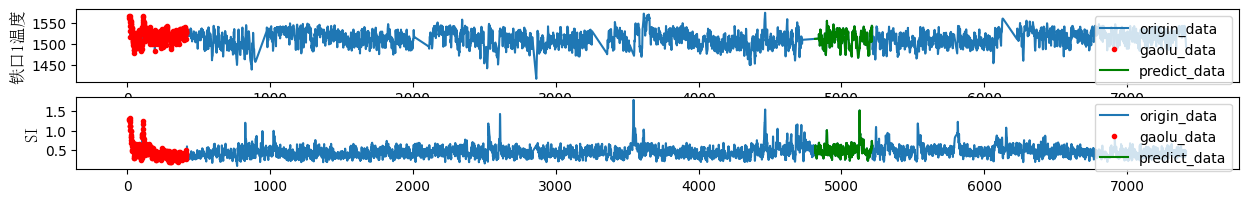

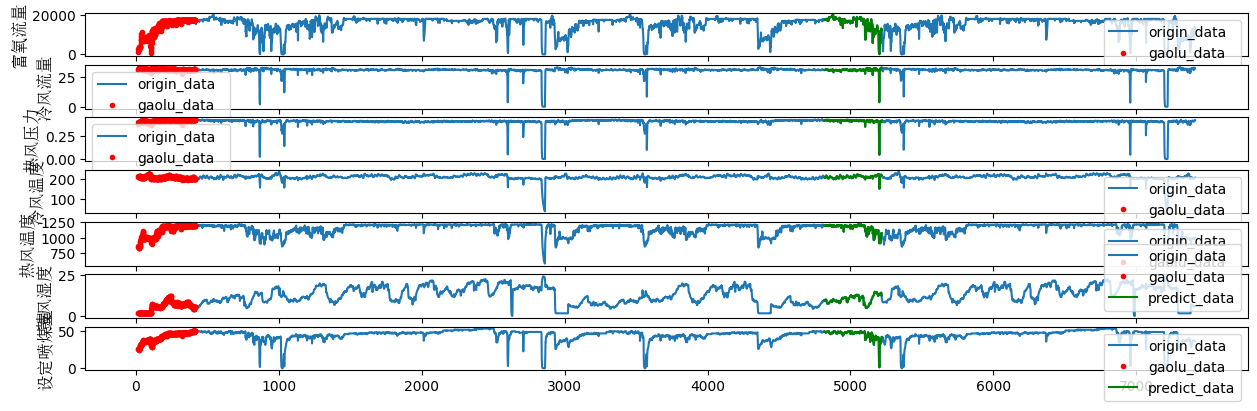

In [29]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='origin_data')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r.', label='gaolu_data')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='predict_data')
    plt.legend()
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



length1 = 400
start1 = 0
length2 = 400
start2 = 4800


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu_process[column].values,column,index_predict,index_gaolu)

plt.figure(figsize=(15, 6))
for idx, column in enumerate(input_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_params_process[time_term].values,df_sheet_params_process[column].values,column,index_predict,index_gaolu)


In [31]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_params_process[input_term[0]].values,
    input_term[1]:   df_sheet_params_process[input_term[1]].values,
    input_term[2]:   df_sheet_params_process[input_term[2]].values,
    input_term[3]:   df_sheet_params_process[input_term[3]].values,
    input_term[4]:   df_sheet_params_process[input_term[4]].values,
    input_term[5]:   df_sheet_params_process[input_term[5]].values,
    input_term[6]:   df_sheet_params_process[input_term[6]].values,
    output_term[0]:  df_sheet_yuansu_process[output_term[0]].values,
    output_term[1]:  df_sheet_yuansu_process[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


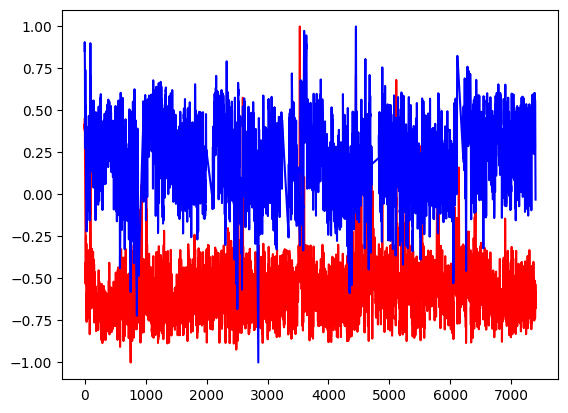

In [32]:
plt.plot(normalized_data_dict['SI'],'r')
plt.plot(normalized_data_dict['铁口1温度'],'b')


In [33]:
# 标定归一化前后数据
data_point = np.array([1500]).reshape(-1, 1)
data1 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

data_point = np.array([1510]).reshape(-1, 1)
data3 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_temp = (data3-data1)/(data4-data2)
print('每摄氏度的输出差：',d_temp)



data_point = np.array([0.50]).reshape(-1, 1)
data1 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

data_point = np.array([0.60]).reshape(-1, 1)
data3 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_yuansu = (data3-data1)/(data4-data2)
print('每0.01浓度的输出差：',(data3-data1))


[0.05471948]
[1500.]
[0.18042565]
[1510.]
每摄氏度的输出差： [0.01257062]
[-0.52854026]
[0.5]
[-0.40998065]
[0.6]
每0.01浓度的输出差： [0.11855962]


In [34]:
isShuffle = True
# isShuffle = False
time_steps = 2


test_size = 0.30
val_size = 0.001
train_size = 1-val_size-test_size


In [35]:
# 组合训练数据--拆分训练、测试集
# 构成    
# X = [X(t),X(t-1),Y(t-1)]
# Y = [Y(t)]
def make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data,index_fanwei):
    X = np.column_stack((u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data))
    y = np.column_stack((y1_data, y2_data))

    X_modified = []
    y_modified = []
    
    for i in range(11,len(y1_data)):
        if i in index_fanwei:
            # print(i)
            # print(df_sheet_yuansu[time_term][i])
            yuansu_time = df_sheet_yuansu[time_term][i]
            closest_10 = df_sheet_params[df_sheet_params[time_term] <= yuansu_time].nlargest(time_steps, time_term)
            # print(closest_10)
            
            index = closest_10.index
            # print(index)
            # print(closest_10.iloc[-1][time_term])
            if closest_10.iloc[-1][time_term] < yuansu_time - time_steps + 1:
                print(i,yuansu_time,'errloss')
            else:

                # print(X[index, :])
                new_x_sample = np.concatenate([X[i, :] for i in index],axis=0)
                # print(new_x_sample)
                # print(y_last, 'y_last time : ',df_sheet_yuansu[time_term][i-1])

                y_last = y[i-1, :]
                new_x_sample = np.concatenate([new_x_sample,y_last],axis=0)

                
                # print(new_x_sample)
                y_sample = y[i, :]  
                X_modified.append(new_x_sample)
                y_modified.append(y_sample)
                print(i,yuansu_time,index[0],index[-1], end='\r')
                # break

    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)
    X_reshaped = X_modified.reshape((X_modified.shape[0], X_modified.shape[1]))

    # 打印新数据的形状
    print("Modified Input Shape:", X_reshaped.shape)
    print("Modified Output Shape:", y_modified.shape)


    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [36]:
def moving_average_filter(data, N):
    """
    这个函数实现了简单的移动平均滤波。
    
    :param data: 输入的数据序列，一般为列表或者NumPy数组。
    :param N: 滑动窗口的大小。
    :return: 经过滤波处理的数据序列。
    """
    filtered_values = []
    window = []
    for i in range(N):
        window.append(0)
    for i in range(len(data)):
        # 将当前数据点加入到窗口
        window.append(data[i])
        # 如果窗口的大小超过了N，就移除最旧的数据点
        if len(window) > N:
            window.pop(0)
        # 计算窗口内的平均值，并加入到结果中
        filtered_values.append(sum(window) / len(window))
    return np.array(filtered_values)

# 使用例子
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
N = 3
filtered_data = moving_average_filter(data, N)
print(filtered_data)

def symmetrical_moving_average(data, N):
    """
    使用对称的移动平均滤波，当前值由其自身及其前后的值决定。
    
    :param data: 输入的数据序列，一般为列表或者NumPy数组。
    :return: 经过滤波处理的数据序列。
    """
    filtered_data = []
    N = 9
    
    # 遍历数据，从索引1开始到倒数第二个元素结束
    for i in range(1, len(data) - 1):
        # 计算当前值及其前后值的平均
        average = (data[i - 1] + data[i] + data[i + 1]) / 3
        filtered_data.append(average)
    
    # 对于序列的第一个和最后一个元素，直接使用原始值
    # 或者可以使用其他边界处理策略
    filtered_data.insert(0, data[0])
    filtered_data.append(data[-1])
    
    return np.array(filtered_data)

# 示例数据
data = [2, 4, 6, 8, 10, 12, 14]
filtered_data = symmetrical_moving_average(data,9)
print(filtered_data)



[0.33333333 1.         2.         3.         4.         5.
 6.         7.         8.         9.        ]
[ 2.  4.  6.  8. 10. 12. 14.]


In [40]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
u5_data = normalized_data_dict[input_term[4]]
u6_data = normalized_data_dict[input_term[5]]
u7_data = normalized_data_dict[input_term[6]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]

filter_windows = 2
# u1_data = moving_average_filter(u1_data, filter_windows)
# u2_data = moving_average_filter(u2_data, filter_windows)
# u3_data = moving_average_filter(u3_data, filter_windows)
# u4_data = moving_average_filter(u4_data, filter_windows)
# u5_data = moving_average_filter(u5_data, filter_windows)
# u6_data = moving_average_filter(u6_data, filter_windows)
# u7_data = moving_average_filter(u7_data, filter_windows)
# y1_data = moving_average_filter(y1_data, filter_windows)
# y2_data = moving_average_filter(y2_data, filter_windows)
u1_data = symmetrical_moving_average(u1_data, filter_windows)
u2_data = symmetrical_moving_average(u2_data, filter_windows)
u3_data = symmetrical_moving_average(u3_data, filter_windows)
u4_data = symmetrical_moving_average(u4_data, filter_windows)
u5_data = symmetrical_moving_average(u5_data, filter_windows)
u6_data = symmetrical_moving_average(u6_data, filter_windows)
u7_data = symmetrical_moving_average(u7_data, filter_windows)
y1_data = symmetrical_moving_average(y1_data, filter_windows)
y2_data = symmetrical_moving_average(y2_data, filter_windows)

num_samples = y2_data.shape[0]
print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_gaolu)



# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
# u5_data = normalized_data_dict[input_term[4]]
# u6_data = normalized_data_dict[input_term[5]]
# u7_data = normalized_data_dict[input_term[6]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]
num_samples = y2_data.shape[0]
print('预测模型数据')
X_predict_train, X_predict_val, X_predict_test,\
y_predict_train, y_predict_val, y_predict_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_predict)



高炉模型数据
Modified Input Shape: (390, 16)
Modified Output Shape: (390, 2)
训练数量： (272, 16) (272, 2)
验证数量： (1, 16) (1, 2)
测试数量： (117, 16) (117, 2)
预测模型数据
Modified Input Shape: (401, 16)
Modified Output Shape: (401, 2)
训练数量： (279, 16) (279, 2)
验证数量： (1, 16) (1, 2)
测试数量： (121, 16) (121, 2)


In [41]:
# 获取模型参数
def get_params(W_b):

    mid_indix = W_b.shape[0]//2-1
    pred_0 = W_b[-2:-1]
    W0 = W_b[:mid_indix]
    b1 = W_b[-1:]
    W1 = W_b[mid_indix:mid_indix*2]
    W_b_0 = np.concatenate((W0, pred_0))
    W_b_1 = np.concatenate((W1, b1))
    # print(mid_indix)

    # print('pred_0:',pred_0.shape)
    # print('W0:',W0.shape)
    # print('b1:',b1.shape)
    # print('W1:',W1.shape)
    return pred_0,W0,b1,W1,W_b_0,W_b_1


In [42]:
# 定义My_LS_SVRModel
class My_M_LS_SVRModel:
    def __init__(self, params):
        C0, C1, C00, gamma= params
        self.C0 = C0
        self.C1 = C1
        self.C00 = C00
        self.gamma = gamma
        self.W_b = None
        self.X_train = None

    def model_train(self, X_train, y_train, K_train):
        def objective(W_b, X, y):
            b0,W0,b1,W1,W_b_0,W_b_1 = get_params(W_b)

            y_pred_0 = np.dot(K_train, W0) + b0
            y_pred_1 = np.dot(K_train, W1) + b1
            errors0 = y[:,0] - y_pred_0
            errors1 = y[:,1] - y_pred_1

            # 损失函数
            loss = ( 0.5 * (np.dot(W0, W0)+np.dot(W1, W1)) 
                    + self.C0 * np.sum(errors0**2) + self.C1 * np.sum(errors1**2)
                    + self.C00 * np.sum(errors0**2 + errors1**2) # L2 范数的平方
                    )
            return loss

        # 初始化权重向量+偏移项b
        initial_W_b = np.zeros((X_train.shape[0])*2+(1)*2)

        # 使用minimize 函数最小化目标函数
        result = minimize(objective, initial_W_b, args=(X_train, y_train),
                            method='L-BFGS-B')
        # 输出最优的权重向量
        best_W_b = result.x
        return best_W_b

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K_train = rbf_kernel(X_train, X_train, gamma=self.gamma)
        self.W_b = self.model_train(X_train, y_train, K_train)

    def my_predict(self, X_test):
        b0,W0,b1,W1,W_b_0,W_b_1 = get_params(self.W_b)
        K_test = rbf_kernel(X_test, self.X_train, gamma=self.gamma)
        y_pred_0 = np.dot(K_test, W0) + b0
        y_pred_1 = np.dot(K_test, W1) + b1
        return y_pred_0, y_pred_1
    


    

# # 示例用法
# params = [8.78525340e+01, 2.01347249e-03]
# # 创建模型
# my_svr_model = My_LS_SVRModel(params=params)
# # 训练模型
# my_svr_model.fit(X_train, y_train)
# # 模型预测
# y_pred = my_svr_model.predict(X_test)


In [43]:
# 定义My_LS_REFLNS
class My_M_LS_REFLNS:
    def __init__(self, params,features_size, ae_hidden_size,lam_l2):
        C0, C1, C00, gamma= params

        self.C = params[0]
        self.gamma = params[1]
        self.X_train = None

        self.ae_input_hidden_w = np.random.uniform(-1, 1, (features_size, ae_hidden_size))
        self.ae_hidden_b = np.random.uniform(-1, 1, (1, ae_hidden_size))
        self.rvflns_w = None
        self.lam_l2=lam_l2
    def my_sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def rvflns_lsm_l2_calculate(self, hidden, y, lam):
        hidden_inv = la.inv(np.dot(np.transpose(hidden), hidden) + lam * np.eye(np.size(hidden, axis=1)))
        w = np.dot(np.dot(hidden_inv, np.transpose(hidden)), y)
        return w



    

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K_train = rbf_kernel(X_train, X_train, gamma=self.gamma)
        print(X_train.shape)
        print(K_train.shape)
        ae_hidden = self.my_sigmoid(np.dot(X_train, self.ae_input_hidden_w) + self.ae_hidden_b)
        print(ae_hidden.shape)
        print(X_train.shape)
        new_combine = np.concatenate([ae_hidden,X_train],axis=1)
        print(new_combine.shape)
        self.rvflns_w = self.rvflns_lsm_l2_calculate(new_combine, y_train, self.lam_l2)


    def my_predict(self, X_test):
        K_test = rbf_kernel(X_test, self.X_train, gamma=self.gamma)
        ae_hidden = self.my_sigmoid(np.dot(X_test, self.ae_input_hidden_w) + self.ae_hidden_b)
        new_combine = np.concatenate([ae_hidden,X_test],axis=1)
        y_pred = np.dot(new_combine, self.rvflns_w)
        return y_pred[:,0],y_pred[:,1]
    


    

# # 示例用法
# params = [8.78525340e+01, 2.01347249e-03]
# # 创建模型
# my_REFLNS_model = My_LS_SVRModel(params=params)
# # 训练模型
# my_REFLNS_model.fit(X_train, y_train)
# # 模型预测
# y_pred = my_REFLNS_model.predict(X_test)


In [44]:
lam_l2 = 0.05


In [45]:
# 创建模
params =   [1 , 1, 0 ,0.1] 
REFLNS_model_gaolu = My_M_LS_REFLNS(params = params,
                                features_size = X_gaolu_train.shape[1], 
                                ae_hidden_size = 272,
                                lam_l2 = lam_l2)
# 训练模型
REFLNS_model_gaolu.fit(X_gaolu_train, y_gaolu_train)



(272, 16)
(272, 272)
(272, 272)
(272, 16)
(272, 288)


训练集
RMSE:  铁口1温度: 3.8624 , SI: 0.0258 
MAPE:  铁口1温度: 0.1966% , SI: 5.0100%
MRE :  铁口1温度: 0.0020  , SI: 0.0501 
per :  铁口1温度: 0.9890  , SI: 1.0000 
测试集
RMSE:  铁口1温度: 4.3416 , SI: 0.0332 
MAPE:  铁口1温度: 0.2206% , SI: 5.5249%
MRE :  铁口1温度: 0.0022  , SI: 0.0552 
per :  铁口1温度: 0.9658  , SI: 0.9744 


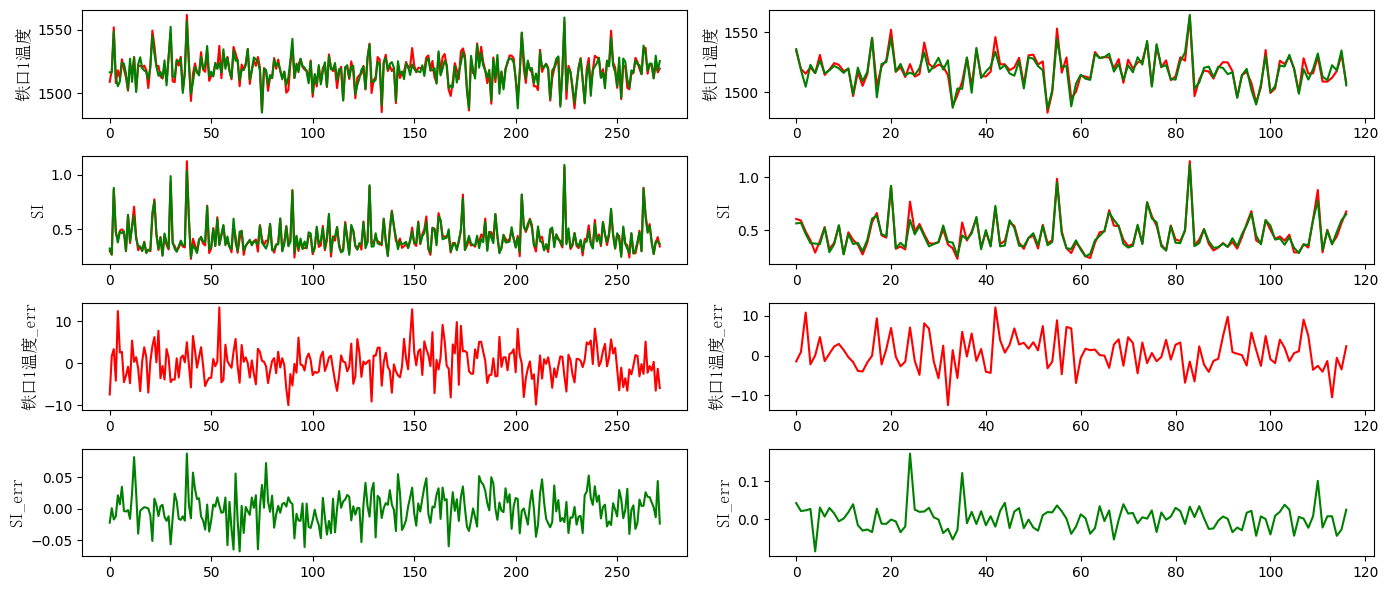

In [46]:
# 高炉模型预测
y_train_pred_0,y_train_pred_1 = REFLNS_model_gaolu.my_predict(X_gaolu_train)
y_test_pred_0,y_test_pred_1 = REFLNS_model_gaolu.my_predict(X_gaolu_test)

base.double_control_train_test_result(scalers,  output_term,
                                        y_gaolu_train,  y_train_pred_0, y_train_pred_1,
                                        y_gaolu_test,   y_test_pred_0,  y_test_pred_1)



In [47]:
# 创建模
params =   [1 , 1, 0 ,0.1] 
REFLNS_model_predict = My_M_LS_REFLNS(params=params,
                                features_size=X_gaolu_train.shape[1], 
                                ae_hidden_size=256,
                                lam_l2 = lam_l2)
# 训练模型
REFLNS_model_predict.fit(X_predict_train, y_predict_train)


(279, 16)
(279, 279)
(279, 256)
(279, 16)
(279, 272)


训练集
RMSE:  铁口1温度: 8.5905 , SI: 0.0888 
MAPE:  铁口1温度: 0.4309% , SI: 14.2824%
MRE :  铁口1温度: 0.0043  , SI: 0.1428 
per :  铁口1温度: 0.7849  , SI: 0.7706 
测试集
RMSE:  铁口1温度: 10.4152 , SI: 0.0848 
MAPE:  铁口1温度: 0.5099% , SI: 13.4658%
MRE :  铁口1温度: 0.0051  , SI: 0.1347 
per :  铁口1温度: 0.7025  , SI: 0.7273 


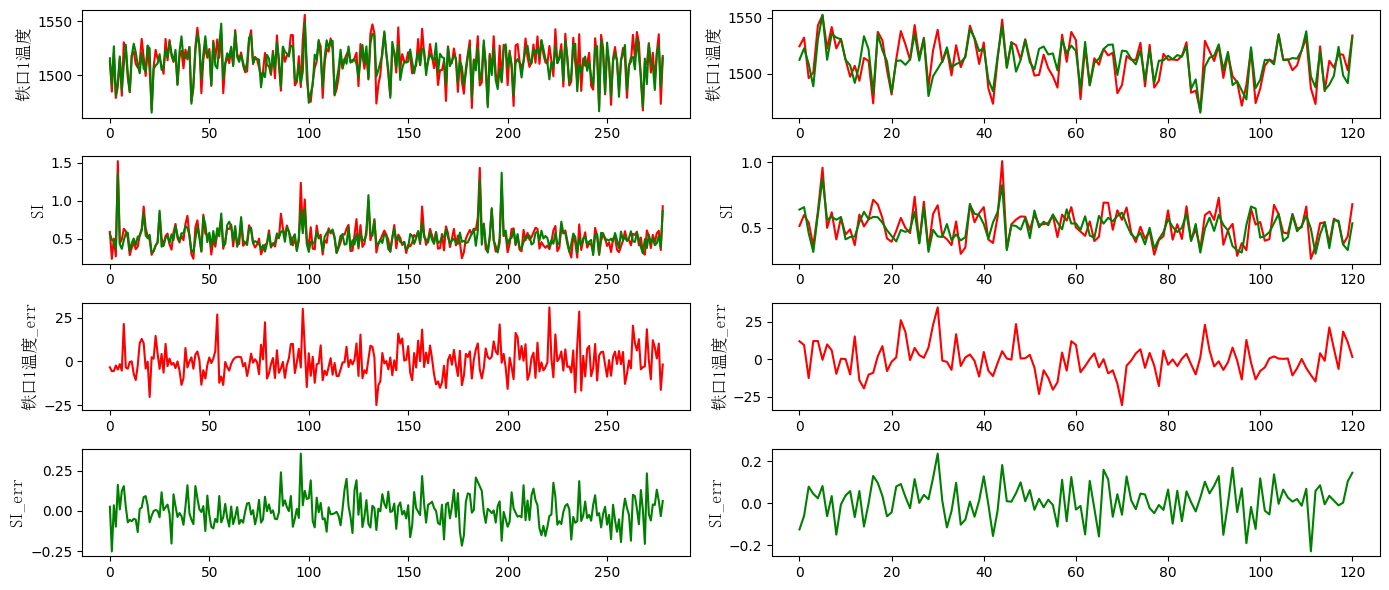

In [48]:
# 预测建模效果
y_train_pred_0,y_train_pred_1 = REFLNS_model_predict.my_predict(X_predict_train)

y_test_pred_0,y_test_pred_1 = REFLNS_model_predict.my_predict(X_predict_test)


base.double_control_train_test_result(scalers,  output_term,
                                        y_predict_train,  y_train_pred_0, y_train_pred_1,
                                        y_predict_test,   y_test_pred_0,  y_test_pred_1)


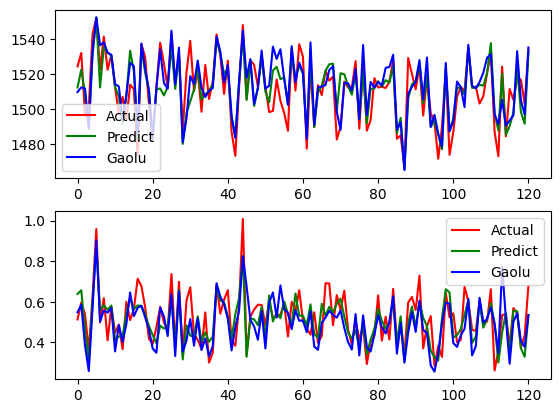

In [53]:
base.gaolu_predict_raw(scalers,output_term,REFLNS_model_predict,REFLNS_model_gaolu,X_predict_test,y_predict_test)


In [54]:
# 生成期望数据
Times = 100

def generate_y_aim_data(Times):

    set_y1 = np.full(Times,1500)
    set_y1[30:] = 1510
    set_y1[60:] = 1505
    set_y1[90:] = 1515
    # set_y1[70:] = 1520
    # set_y1[90:] = 1525

    set_y2 = np.full(Times,0.44)
    set_y2[15:] = 0.48
    set_y2[45:] = 0.52
    set_y2[75:] = 0.44
    # 限制设定值在 -1 到 1 之间
    # set_y1 = np.clip(set_y1, -1, 1)
    # set_y2 = np.clip(set_y2, -1, 1)


    set_y1_trans = scalers[output_term[0]].transform(set_y1.reshape(-1,1)).flatten()
    set_y2_trans = scalers[output_term[1]].transform(set_y2.reshape(-1,1)).flatten()

    return set_y1, set_y2, set_y1_trans, set_y2_trans

# # 调用示例
# set_y1, set_y2, set_y1_trans, set_y2_trans= generate_y_aim_data(Times)
# plt.plot(set_y1_trans)
# plt.plot(set_y2_trans)
# plt.title('y_sp')
# plt.show()



In [55]:
# 生成参考轨迹
def get_yr(aim_value,current_value,alpha,P):
    # 生成设定信号
    setpoint_signal = np.full(10, aim_value)
    # 初始化参数
    alpha = alpha
    y_r = np.zeros(P)
    y_r[0] = current_value
    # 模拟一阶模型
    for k in range(1,P):
        y_r[k] = alpha * y_r[k-1] + (1 - alpha) * aim_value

    # # 绘制结果
    # plt.plot(setpoint_signal, label='Setpoint Signal')
    # plt.plot(y_r,'o-', label='Output Signal (Tracked)')
    # plt.legend()
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Tracking Setpoint Signal with One-Order Model')
    # plt.show()
    return y_r
# 测试
y_r = get_yr(1,-0.5,0.667,5+1)


In [56]:
#生成控制时域的数据格式
def generate_k_data(u1_data, u2_data, u3_data, u4_data, u5_data, u6_data, u7_data, y1_data,y2_data, num_samples, P):
    nearest_index = np.abs(y1_data - (-0.5)).argmin()
    # 生成随机索引值
    #从原有数据的randint时刻开始往下进行控制
    randint = np.random.randint(1, num_samples - 2 - P - 1)
    randint = nearest_index  # 如果你希望使用固定的值而不是随机生成
    # randint = 250  # 如果你希望使用固定的值而不是随机生成
    print(randint)
    # 提取数据并构成 k_data
    # 第一次得到下面五个变量，固定好格式构成k_data
    u1   = u1_data[randint  :randint+3  ]
    u2   = u2_data[randint  :randint+3  ]
    u3   = u3_data[randint  :randint+3  ]
    u4   = u4_data[randint  :randint+3  ]
    u5   = u2_data[randint  :randint+3  ]
    u6   = u3_data[randint  :randint+3  ]
    u7   = u4_data[randint  :randint+3  ]

    y1   = y1_data[randint  :randint+3  ]
    y2   = y2_data[randint  :randint+3  ]
    k_data = np.concatenate((u1, u2, u3, u4, u5, u6, u7, y1, y2), axis=0)
    print(k_data.shape)

    k_data = np.zeros_like(k_data)
    return k_data



In [57]:
# 定义单时刻的MPC问题优化
def my_MPC(k_data,params,M,P,y1_aim,y2_aim,isprint):
    h1 = 1.0
    h2 = 1.0
    lamda1 = 0.001
    lamda2 = 0.001
    lamda3 = 0.001
    lamda4 = 0.001
    y1_percent = 1.0
    y2_percent = 1.0

    # 从固定格式k_data里面读取信息
    u1   = k_data[0:3]
    u2   = k_data[3:6]
    u3   = k_data[6:9]
    u4   = k_data[9:12]
    u5   = k_data[12:15]
    u6   = k_data[15:18]
    u7   = k_data[18:21]

    y1   = k_data[21:24]
    y2   = k_data[24:27]

    
    # 获取猜测值[h U1 U2]
    # h, U1, U2  =params[0], params[1:M+1],params[M+1:]
    U1, U2, U3, U4, U5, U6, U7  =params[0:M], params[M:2*M],params[2*M:3*M], params[3*M:4*M], params[4*M:5*M],params[5*M:6*M], params[6*M:7*M]
    
    # 整理数据见   MPC推到.escel
    u1   = np.concatenate((u1,U1,U1[-1]*np.ones(P-M)))
    u2   = np.concatenate((u2,U2,U2[-1]*np.ones(P-M)))
    u3   = np.concatenate((u3,U3,U3[-1]*np.ones(P-M)))
    u4   = np.concatenate((u4,U4,U4[-1]*np.ones(P-M)))
    u5   = np.concatenate((u5,U5,U5[-1]*np.ones(P-M)))
    u6   = np.concatenate((u6,U6,U6[-1]*np.ones(P-M)))
    u7   = np.concatenate((u7,U7,U7[-1]*np.ones(P-M)))
    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))
    if isprint:
        print(u1.round(4))
        print(u2.round(4))
        print(u3.round(4))
        print(u4.round(4))
        print(u5.round(4))
        print(u6.round(4))
        print(u7.round(4))
        print(y1.round(4))    
        print(y2.round(4))
        print('开始预测')

    y1_k = y1[2]
    y2_k = y2[2]





    # 总共预测 P+1 次
    # 对k时刻进行预测-----1次
    for j in range(1):   # j = 0
        x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],
                                u5[j+2],u6[j+2],u7[j+2],
                                u1[j+1],u2[j+1],u3[j+1],u4[j+1],
                                u5[j+1],u6[j+1],u7[j+1],
                                y1[j+1],y2[j+1]))
        # x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_m_k, y2_m_k = REFLNS_model_predict.my_predict(x)
        E1_k = y1_k - y1_m_k
        E2_k = y2_k - y2_m_k
        if isprint:
            print(j,'mode = 0')
            print(x.round(4))
            print(y1_k.round(4),y2_k.round(4))
            print(y1_m_k.round(4),y2_m_k.round(4))

    # 对控制时刻进行预测-----M次
    for j in range(1,M+1):  # j = 1,2
        x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],
                                u5[j+2],u6[j+2],u7[j+2],
                                u1[j+1],u2[j+1],u3[j+1],u4[j+1],
                                u5[j+1],u6[j+1],u7[j+1],
                                y1[j+1],y2[j+1]))
        # x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j, y2_k_j = REFLNS_model_predict.my_predict(x)
        y1[j+2] = y1_k_j.item()
        y2[j+2] = y2_k_j.item()
        if isprint:
            print(j,'mode = 1')
            print(x.round(4))
            print(y1_k_j.round(4),y2_k_j.round(4))
            print('更新后:')
            print(u1.round(4))
            print(u2.round(4))
            print(u3.round(4))
            print(u4.round(4))
            print(u5.round(4))
            print(u6.round(4))
            print(u7.round(4))
            print(y1.round(4))    
            print(y2.round(4))

    # 对控制时域外的部分进行预测-----P-M次
    # 注意：这部分的信号是保持控制不变下进行
    for j in range(M+1,P+1):  #j = 3,4
        x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],
                                u5[j+2],u6[j+2],u7[j+2],
                                u1[j+1],u2[j+1],u3[j+1],u4[j+1],
                                u5[j+1],u6[j+1],u7[j+1],
                                y1[j+1],y2[j+1]))
        # x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j, y2_k_j = REFLNS_model_predict.my_predict(x)
        y1[j+2] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+2] = y2_k_j.item()
        if isprint:
            print(j,'mode = 2')
            print(x.round(4))
            print(y1_k_j.round(4),y2_k_j.round(4))
            print('更新后:')
            print(u1.round(4))
            print(u2.round(4))
            print(u3.round(4))
            print(u4.round(4))
            # print(u5.round(4))
            # print(u6.round(4))
            # print(u7.round(4))
            print(y1.round(4))    
            print(y2.round(4))



    # k_data2 = np.concatenate((u1[1:4],u2[1:4],u3[1:4],u4[1:4],y1[1:4],y2[1:4]),axis=0)  
    k_data2 = np.concatenate((u1[1:4],u2[1:4],u3[1:4],u4[1:4],u5[1:4],u6[1:4],u7[1:4],y1[1:4],y2[1:4]),axis=0)


    if isprint:
        print('更新k_data')
        print(k_data2.round(4))


    #获取参考轨迹
    # 一定要对照好做差的序列
    y1_r_aim  = get_yr(y1_aim,y1_k,0.1,P+1)
    y1_r = y1_r_aim[1:] 


    y2_r_aim  = get_yr(y2_aim,y2_k,0.1,P+1)
    y2_r = y2_r_aim[1:] 

    y1_M_k = y1[3:]
    y2_M_k = y2[3:]
    if isprint==1:
        print('反馈补偿:')
        print('y1_k',y1_k.round(4))  
        print('y1_m_k',y1_m_k.round(4))    
        print('h*E1_k',(h1*E1_k).round(4)) 
        print('y2_k',y2_k.round(4))  
        print('y2_m_k',y2_m_k.round(4))   
        print('h*E2_k',(h2*E2_k).round(4))

        print('temp:')
        print('y1_aim',y1_aim.round(4))
        print('y1_r_aim',y1_r_aim.round(4))
        print('y1_r',y1_r.round(4))
        print('y1_M_k',y1_M_k.round(4))
        print('y1_M_k+h1*E1_k',(y1_M_k+h1*E1_k).round(4))

        print('Si_percent:')
        print('y2_aim',y2_aim.round(4))
        print('y2_r_aim',y2_r_aim.round(4))
        print('y2_r',y2_r.round(4))
        print('y2_M_k',y2_M_k.round(4))
        print('y2_M_k+h2*E2_k',(y2_M_k+h2*E2_k).round(4))

        print('u:')
        print(u1[2:].round(4))
        print(u2[2:].round(4))
        print(u3[2:].round(4))
        print(u4[2:].round(4))
        
    # 计算mse
    # lamda1太大的话会导致y1_r和y1_M_k的误差加大*****************导致超调的原因\与目标值之间存在间隙


    # y1_err = y1_percent*np.sum((y1_r-(y1_M_k+h1*E1_k))**2) 
    # y2_err = y2_percent*np.sum((y2_r-(y2_M_k+h2*E2_k))**2) 
    # u1_power = lamda1*np.sum((np.diff(u1[2:]))**2)
    # u2_power = lamda2*np.sum((np.diff(u2[2:]))**2)
    # u3_power = lamda3*np.sum((np.diff(u3[2:]))**2)
    # u4_power = lamda4*np.sum((np.diff(u4[2:]))**2)
    # u5_power = lamda2*np.sum((np.diff(u5[2:]))**2)
    # u6_power = lamda3*np.sum((np.diff(u6[2:]))**2)
    # u7_power = lamda4*np.sum((np.diff(u7[2:]))**2)

    y1_err = y1_percent*np.sum(np.fabs(y1_r-(y1_M_k+h1*E1_k))) 
    y2_err = y2_percent*np.sum(np.fabs(y2_r-(y2_M_k+h2*E2_k))) 
    u1_power = lamda1*np.sum((np.fabs(np.diff(u1))))
    u2_power = lamda2*np.sum((np.fabs(np.diff(u2))))
    u3_power = lamda3*np.sum((np.fabs(np.diff(u3))))
    u4_power = lamda4*np.sum((np.fabs(np.diff(u4))))
    u5_power = lamda2*np.sum((np.fabs(np.diff(u5))))
    u6_power = lamda3*np.sum((np.fabs(np.diff(u6))))
    u7_power = lamda4*np.sum((np.fabs(np.diff(u7))))

    mse = (0
            +y1_err
            +y2_err
            +u1_power
            +u2_power
            +u3_power
            +u4_power
            +u5_power
            +u6_power
            +u7_power
            )
    
    # print('mse {:.7f}'.format(mse))
    if isprint==1:
        print('mse {:.7f}'.format(mse))
        print('1111 {:.7f}'.format(y1_err))
        print('2222 {:.7f}'.format(y2_err))
        print('1111 {:.7f}'.format(u1_power))
        print('2222 {:.7f}'.format(u2_power))
        print('3333 {:.7f}'.format(u3_power))
        print('4444 {:.7f}'.format(u4_power))



    return mse , k_data2, E1_k*h1,  E2_k*h2
    # return mse , k_data2, E1_k*h1


In [62]:
Times = 40
iscontrol = True
# iscontrol = False


In [63]:
# 对未来Times周期预测控制
max_control = 1.0
# 期望设定值
set_y1, set_y2, set_y1_trans, set_y2_trans = generate_y_aim_data(Times)

# MPC参数
P = 4  # 预测时域长度  增大P能平稳些
M = 2  # 控制时域长度
#生成控制时域的数据格式
k_data = generate_k_data(u1_data, u2_data, u3_data, u4_data,
                        u5_data, u6_data, u7_data, 
                        y1_data, y2_data, num_samples, P)


# MPC控制循环   迭代的只有：k_data
all_pred_y1 = []
all_pred_y2 = []
all_pred_u1 = []
all_pred_u2 = []
all_pred_u3 = []
all_pred_u4 = []
all_pred_u5 = []
all_pred_u6 = []
all_pred_u7 = []
# MPC控制循环40
for k in range(Times):
    if iscontrol == False:
        break

    print(f"这是对第{k}时刻的最优U1、U2输入求解")

    # 定义优化目标函数
    def objective_function(params, *k_data):
        mse, k_data2, E1_k_0, E2_k_0 = my_MPC(k_data=k_data[0], params=params, 
                                M=M, P=P, 
                                y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                                isprint = 0) 
        return mse
    
    # 初始猜测值[h U1 U2]   定义参数的上下限    设置退出条件
    params = np.concatenate([np.ones(M), np.ones(M),np.ones(M), np.ones(M), np.ones(M),np.ones(M), np.ones(M)])
    # params = np.concatenate([np.ones(M), np.ones(M),np.ones(M), np.ones(M)])
    bounds = [(-max_control, max_control) for _ in range(7 * M)]
    exit_conditions = {'maxiter': 1000} 
    # 进行优化
    result = minimize(objective_function, params, method='L-BFGS-B', 
                    bounds=bounds, args=k_data)#args传进来的是一个元组


    U1, U2, U3, U4, U5, U6, U7 =    result.x[0:M], result.x[M:2*M], \
                                    result.x[2*M:3*M], result.x[3*M:4*M], \
                                    result.x[4*M:5*M], result.x[5*M:6*M], \
                                    result.x[6*M:7*M]
    

    u1   = k_data[0:3]
    u2   = k_data[3:6]
    u3   = k_data[6:9]
    u4   = k_data[9:12]
    u5   = k_data[12:15]
    u6   = k_data[15:18]
    u7   = k_data[18:21]

    y1   = k_data[21:24]
    y2   = k_data[24:27]
    u1   = np.concatenate((u1,U1,U1[-1]*np.ones(P-M)))
    u2   = np.concatenate((u2,U2,U2[-1]*np.ones(P-M)))
    u3   = np.concatenate((u3,U3,U3[-1]*np.ones(P-M)))
    u4   = np.concatenate((u4,U4,U4[-1]*np.ones(P-M)))
    u5   = np.concatenate((u5,U5,U5[-1]*np.ones(P-M)))
    u6   = np.concatenate((u6,U6,U6[-1]*np.ones(P-M)))
    u7   = np.concatenate((u7,U7,U7[-1]*np.ones(P-M)))
    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))



    # 将控制序列第一个数作用于高炉
    j = 1
    x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],u5[j+2],u6[j+2],u7[j+2],
                            u1[j+1],u2[j+1],u3[j+1],u4[j+1],u5[j+1],u6[j+1],u7[j+1],
                            y1[j+1],y2[j+1]))
    # x = x.reshape((x.shape[0], 1, x.shape[1]))
    y1_pred0, y2_pred0 = REFLNS_model_predict.my_predict(x)
    y1_pred, y2_pred = REFLNS_model_gaolu.my_predict(x)
    


    # 更新k_data
    params = np.concatenate((U1, U2, U3, U4, U5, U6, U7),axis=0)
    mse, k_data2, E1_k_0, E2_k_0 =my_MPC(k_data=k_data,params=params,
                            M=M,P=P, 
                            y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                            isprint = 0) 


    print(  '1设定',set_y1_trans[k].round(4),\
            '预测',y1_pred0.round(4),\
            '高炉', y1_pred.round(4),\
            '高炉与设定误差',(set_y1_trans[k]-y1_pred).round(4),(set_y1_trans[k]-y1_pred).round(4)/d_temp,\
            '模型误差',(y1_pred0 - y1_pred).round(4),\
            '校正值',E1_k_0.round(4))
    print(  '2设定',set_y2_trans[k].round(4),\
            '预测',y2_pred0.round(4),\
            '高炉', y2_pred.round(4),\
            '高炉与设定误差',(set_y2_trans[k]-y2_pred).round(4),(set_y2_trans[k]-y2_pred).round(4)/d_yuansu,\
            '模型误差',(y2_pred0 - y2_pred).round(4),\
            '校正值',E2_k_0.round(4))




    all_pred_y1.append(y1_pred)
    all_pred_y2.append(y2_pred)
    all_pred_u1.append(U1[0])
    all_pred_u2.append(U2[0])
    all_pred_u3.append(U3[0])
    all_pred_u4.append(U4[0])
    all_pred_u5.append(U5[0])
    all_pred_u6.append(U6[0])
    all_pred_u7.append(U7[0])
    k_data2[23] = y1_pred.item()
    k_data2[26] = y2_pred.item()
    k_data = k_data2
    # 进入下一时刻，更新预测时域、控制时域，即k_data


2838
(27,)
这是对第0时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.2045] 高炉 [0.1639] 高炉与设定误差 [-0.1092] [-8.68692381] 模型误差 [0.0406] 校正值 [-0.1553]
2设定 -0.5997 预测 [-0.3229] 高炉 [-0.5377] 高炉与设定误差 [-0.062] [-0.05229437] 模型误差 [0.2148] 校正值 [0.1155]
这是对第1时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.1062] 高炉 [0.2206] 高炉与设定误差 [-0.1658] [-13.18948689] 模型误差 [-0.1144] 校正值 [-0.0406]
2设定 -0.5997 预测 [-0.3788] 高炉 [-0.4854] 高炉与设定误差 [-0.1142] [-0.09632285] 模型误差 [0.1066] 校正值 [-0.2148]
这是对第2时刻的最优U1、U2输入求解
1设定 0.0547 预测 [-0.0431] 高炉 [0.0881] 高炉与设定误差 [-0.0334] [-2.65698952] 模型误差 [-0.1312] 校正值 [0.1144]
2设定 -0.5997 预测 [-0.4816] 高炉 [-0.547] 高炉与设定误差 [-0.0527] [-0.04445021] 模型误差 [0.0654] 校正值 [-0.1066]
这是对第3时刻的最优U1、U2输入求解
1设定 0.0547 预测 [-0.0731] 高炉 [0.1063] 高炉与设定误差 [-0.0516] [-4.10481015] 模型误差 [-0.1794] 校正值 [0.1312]
2设定 -0.5997 预测 [-0.529] 高炉 [-0.5903] 高炉与设定误差 [-0.0094] [-0.0079285] 模型误差 [0.0612] 校正值 [-0.0654]
这是对第4时刻的最优U1、U2输入求解
1设定 0.0547 预测 [-0.1195] 高炉 [0.0035] 高炉与设定误差 [0.0512] [4.07298992] 模型误差 [-0.1231] 校正值 [0.1794]
2设定 -0.5997 预测 [-0.5375]

上线分别是：[2.00736825e+04 2.48731508e-04]、[3.37254652e+01 3.41094835e-06]、[ 4.32087465e-01 -2.78527280e-04]、[235.88697211  37.56529469]、[1220.02980501  575.46498828]、[2.43904875e+01 1.16388021e-02]、[5.35000000e+01 1.43051147e-06]
平均误差 8.1746
平均误差 0.0325


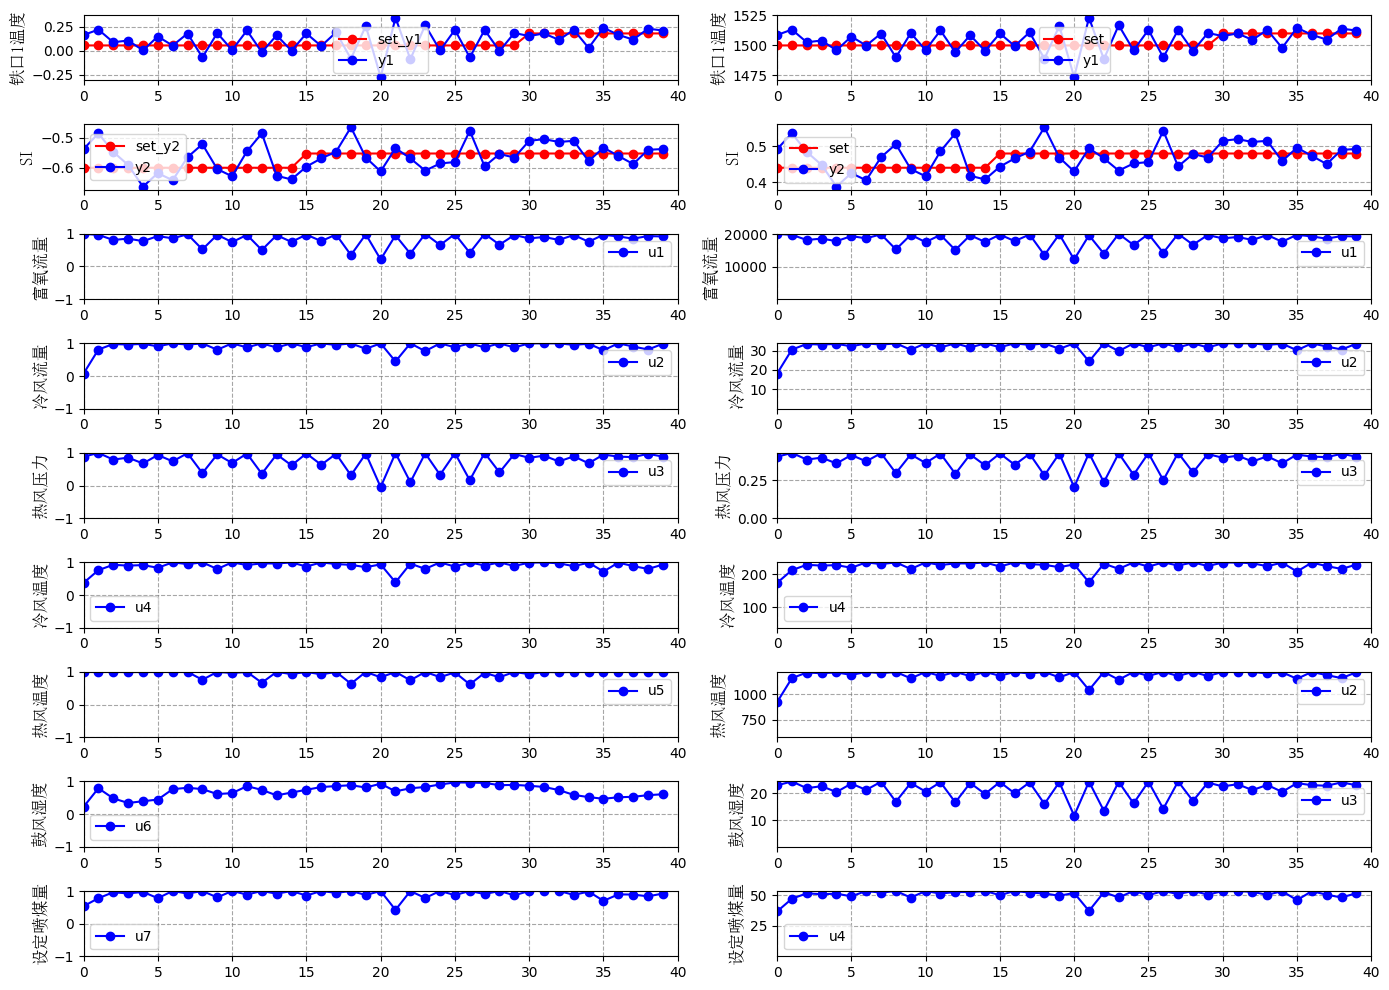

In [64]:
# 数据转换、
base.data_tranform_plot_7_2(scalers,Times ,max_control,
                        output_term,input_term,
                        set_y1,set_y2,set_y1_trans,set_y2_trans,
                        all_pred_y1, all_pred_y2,
                        all_pred_u1,
                        all_pred_u2,
                        all_pred_u3,
                        all_pred_u4,
                        all_pred_u5,
                        all_pred_u6,
                        all_pred_u7)
